In [1]:
import cv2
import sys
import os
import glob
import random
from skimage import data, exposure, img_as_float
import matplotlib.pyplot as plt
from Misc.MiscUtils import *
from Misc.DataUtils import *
import numpy as np
import time
import argparse
import shutil
from io import StringIO
import string
from termcolor import colored, cprint
import math as m
from tqdm import tqdm
import csv
from sklearn.preprocessing import StandardScaler
# Don't generate pyc codes
sys.dont_write_bytecode = True

import tensorflow as tf

from keras import backend as K

from keras.utils import Sequence
from keras.initializers import VarianceScaling
from keras.models import Sequential
from keras.layers import  Activation, Dense, Dropout, Conv2D, MaxPooling2D, Flatten, BatchNormalization, InputLayer
from keras import optimizers
from keras.callbacks import ModelCheckpoint

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2710758021232329882
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 8605475485210445649
physical_device_desc: "device: XLA_GPU device"
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 14939082357477608591
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7679049728
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5927210066406495679
physical_device_desc: "device: 0, name: GeForce RTX 2070 with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 7.5"
]
Num GPUs Available:  1


In [2]:

def HomographyNet():

#     hidden_layer_size, num_classes = 1000, 8
    input_shape = (128, 128, 2)
    kernel_size = 3
    pool_size = 2
    filters = 64
    dropout = 0.5

    kernel_initializer = VarianceScaling(scale=2.0)
    
    model = Sequential()
    model.add(InputLayer(input_shape))
    ## conv2d 128
    model.add(Conv2D(filters=filters,kernel_size = kernel_size, activation ='relu', padding ='same'))
    model.add(BatchNormalization())
    
    ## conv2d 128
    model.add(Conv2D(filters = filters,kernel_size = kernel_size, activation = 'relu', padding = 'same'))
    model.add(BatchNormalization())
    
    model.add(MaxPooling2D(pool_size))
    
    ## conv2d 64
    model.add(Conv2D(filters=filters,kernel_size=kernel_size, activation = 'relu', padding = 'same'))
    model.add(BatchNormalization())
    ## conv2d 64
    model.add(Conv2D(filters=filters, kernel_size=kernel_size, activation='relu', padding='same'))
    model.add(BatchNormalization())
    
    model.add(MaxPooling2D(pool_size))
    
    ## conv2d 32 2x Filters
    model.add(Conv2D(filters=filters*2,kernel_size=kernel_size, activation='relu', padding='same',))
    model.add(BatchNormalization())
    ## conv2d 32 2x Filters
    model.add(Conv2D(filters=filters*2,kernel_size=kernel_size, activation='relu', padding='same',))
    model.add(BatchNormalization())
    
    model.add(MaxPooling2D(pool_size))
    
    ## conv2d 16 2x Filters
    model.add(Conv2D(filters=filters*2, kernel_size=kernel_size, activation='relu', padding='same',))
    model.add(BatchNormalization())
    ## conv2d 16 2x Filters
    model.add(Conv2D(filters=filters*2, kernel_size=kernel_size, activation='relu', padding='same',))
    model.add(BatchNormalization())
    
    model.add(Flatten())
    model.add(Dropout(dropout))
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(dropout))
    #for regression model
    model.add(Dense(8))
    return model

#Loss Function using SMSE
def L2_loss(y_true, y_pred):
    return K.sqrt(K.sum(K.square(y_pred - y_true), axis=-1, keepdims=True))

In [3]:
all_labels = pd.read_csv("/home/gokul/CMSC733/hgokul_p1/Phase2/Data/Train_dummy/H4.csv", index_col =False)
all_labels = all_labels.to_numpy()
all_patchNames = pd.read_csv("/home/gokul/CMSC733/hgokul_p1/Phase2/Data/Train_dummy/ImageFileNames.csv")
all_patchNames = all_patchNames.to_numpy()
print(len(all_patchNames),len(all_labels))

5000 5000


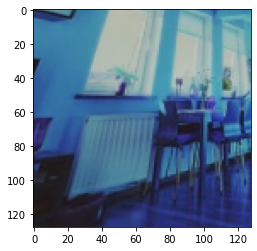

In [12]:
im1 = cv2.imread("/home/gokul/CMSC733/hgokul_p1/Phase2/Data/Train_dummy/PB/"+ str(all_patchNames[0][0]))
plt.imshow(im1)

In [15]:
X_train = []
for i, p in enumerate(all_patchNames[:1000]):

    tPatchA = cv2.imread("/home/gokul/CMSC733/hgokul_p1/Phase2/Data/Train_dummy/PA/"+ str(p[0]), cv2.IMREAD_GRAYSCALE)
    tPatchB = cv2.imread("/home/gokul/CMSC733/hgokul_p1/Phase2/Data/Train_dummy/PB/"+ str(p[0]), cv2.IMREAD_GRAYSCALE)
    tPatch = np.dstack((tPatchA, tPatchB))    
    X_train.append(tPatch)
X_train = np.array(X_train)    
Y_train = all_labels[:1000]

print(X_train.shape,Y_train.shape)

(1000, 128, 128, 2) (1000, 8)


In [16]:
epochs = 20
batch_size = 64
number_of_training_samples = X_train.shape[0]
num_iterations_per_epoch = int(number_of_training_samples / batch_size)
       
model = HomographyNet()
adam = optimizers.Adam(lr=0.0005)
model.compile(loss= L2_loss, optimizer=adam, metrics=['mean_absolute_error'])

model.fit(X_train,Y_train,epochs=epochs,batch_size = batch_size, verbose=1, shuffle = False)





Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor

Epoch 1/20
1000/1000 [==============================] - 23s - loss: 52.1902 - mean_absolute_error: 16.0284    
Epoch 2/20
1000/1000 [==============================] - 14s - loss: 46.6745 - mean_absolute_error: 14.2726    
Epoch 3/20
1000/1000 [==============================] - 12s - loss: 39.0296 - mean_absolute_error: 11.7406    
Epoch 4/20
1000/1000 [==============================] - 13s - loss: 32.1978 - mean_absolute_error: 9.5409    
Epoch 5/20
1000/1000 [==============================] - 13s - loss: 29.0401 -

In [29]:

Y_test = model.predict(X_train[1].reshape(1,128,128,2))

In [30]:
Y_test,  Y_train[1]

(array([[ 13.281464 ,  11.661555 ,   4.0935087,   9.679317 , -17.351686 ,
          -5.650683 ,  16.521486 ,   8.417555 ]], dtype=float32),
 array([ 19.,  24.,   0.,  10., -27.,  -7.,  19.,  17.]))

In [20]:
model.save('model1kOF.h5')

In [33]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
mae = mean_absolute_error(Y_test, Y_train[1].reshape(1,8))
mae

5.566220223903656